## <span style="color:#db7d60">Setup</span>

In [2]:
%load_ext autoreload
%autoreload 2

import json
import math
import pickle
import numpy as np
import pandas as pd
import textwrap
import sys
from pathlib import Path
from IPython.display import display, Markdown
import matplotlib.pyplot as plt

# pUtil needs to be loaded from the root directory
parent_dir = Path().resolve().parent
sys.path.insert(0, str(parent_dir))

import pUtil
from analysis_common import *
import data_manager
import analysis as anal

import vector
from particle import Particle
from particle import PDGID

plt.rcParams['figure.figsize'] = (21, 6)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

/global/homes/e/eshy/.local/lib/python3.11/site-packages/coffea/nanoevents/schemas/fcc.py:5: FutureWarning: In version 2025.1.0 (target date: 2024-12-31 11:59:59-06:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import vector


## <span style="color:#db7d60">Analysis</span>

In [3]:

lr_scheduler = 'cosine_annealing_with_warmup'
warmup_iters = 100
learning_rate = 0.001
min_lr = 0.00001
lr_decay_iters = 1000

cycle_mult = 1
base_lr_decay_mult = 1

# learning rate decay scheduler
def get_lr(it):
    if lr_scheduler == 'cosine_annealing_with_warmup':
        # 1) linear warmup for warmup_iters steps
        if it < warmup_iters:
            return learning_rate * it / warmup_iters
        # 2) if it > lr_decay_iters, return min learning rate
        if it >= lr_decay_iters:
            return min_lr
        # 3) in between, use cosine decay down to min learning rate
        decay_ratio = (it - warmup_iters) / (lr_decay_iters - warmup_iters)
        assert 0 <= decay_ratio <= 1
        coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff ranges 0..1
        return min_lr + coeff * (learning_rate - min_lr)
    elif lr_scheduler == 'cosine_with_warmup':
        # 1) linear warmup for warmup_iters steps
        if it < warmup_iters:
            return learning_rate * it / warmup_iters
        # 3) in between, use cosine decay down to min learning rate
        decay_ratio = (it - warmup_iters) / (lr_decay_iters - warmup_iters)
        coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff ranges 0..1
        return min_lr + coeff * (learning_rate - min_lr)
    elif lr_scheduler == 'cosine_annealing_with_warm_restarts':
        # 1) linear warmup for warmup_iters steps
        if it < warmup_iters:
            return learning_rate * (it / warmup_iters)
        # Adjust iteration to account for warmup
        it -= warmup_iters
        # 2) Find current cycle and position in the cycle
        cycle = 0
        curr_cycle_len = lr_decay_iters
        iter_in_cycle = it
        while iter_in_cycle >= curr_cycle_len:
            iter_in_cycle -= curr_cycle_len
            cycle += 1
            curr_cycle_len = int(curr_cycle_len * cycle_mult)
        # 3) Decay the base learning rate for the current cycle
        curr_base_lr = learning_rate * (base_lr_decay_mult ** cycle)
        # 4) Normalized progress within the cycle
        t = iter_in_cycle / curr_cycle_len
        # 5) Cosine annealing
        lr = min_lr + 0.5 * (curr_base_lr - min_lr) * (1 + math.cos(math.pi * t))
        return lr

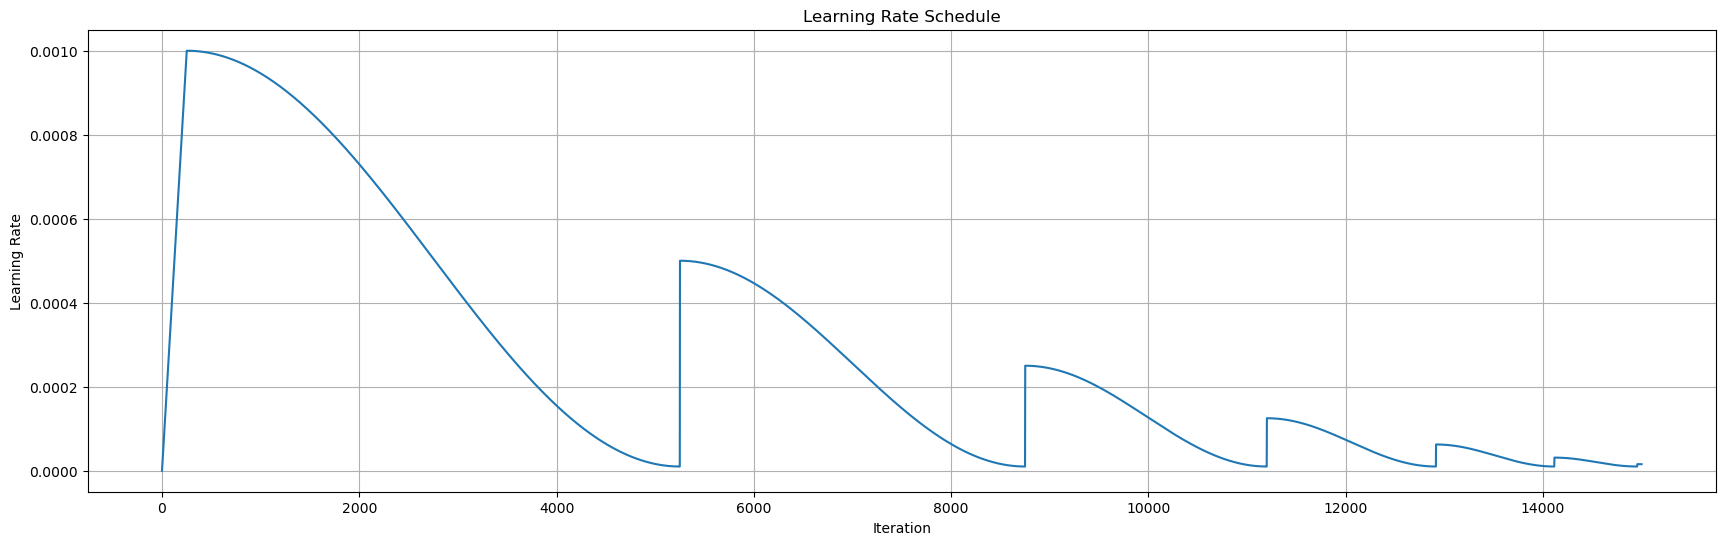

1.614302179157273e-05 1.609427140540686e-05 1.604571403147985e-05


In [5]:
lr_scheduler = 'cosine_annealing_with_warm_restarts'
warmup_iters = 250
learning_rate = 0.001
min_lr = 1e-05
lr_decay_iters = 5000
cycle_mult = 0.7
base_lr_decay_mult = 0.5

points = []
for i in range(15000):
    points.append(get_lr(i))
    
plt.plot(points)
plt.xlabel('Iteration')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.grid()
plt.show()

print(get_lr(4999), get_lr(5000), get_lr(5001))